In [9]:
import numpy as np
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import logp as logp_scale
from utils import logf_Jacobian, quick_MVN_marginals, quick_MVN_scatter
from scipy.stats import multivariate_normal
from Zappa.zappa import zappa_persistent, zappa_sampling
from scipy.stats import expon
from numpy.random import exponential
from utils import normalize
from Zappa.zappa import project
import matplotlib.pyplot as plt
from utils import angle_between

In [47]:
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
x = target.rvs()
z = target.pdf(x)
ellipse = RotatedEllipse(mu, Sigma, z)

In [32]:
s = 0.5
sexp = 0.1
n = 10000
tol = 1.48e-08
logf = lambda xy: logf_Jacobian(xy, Sigma)
logp = lambda xy: logp_scale(xy, s)
logp_exp = lambda xy: expon.logpdf(xy, scale=sexp)

In [33]:
samples1 = zappa_sampling(x, ellipse, logf, logp, n, s, tol, a_guess=1.0)

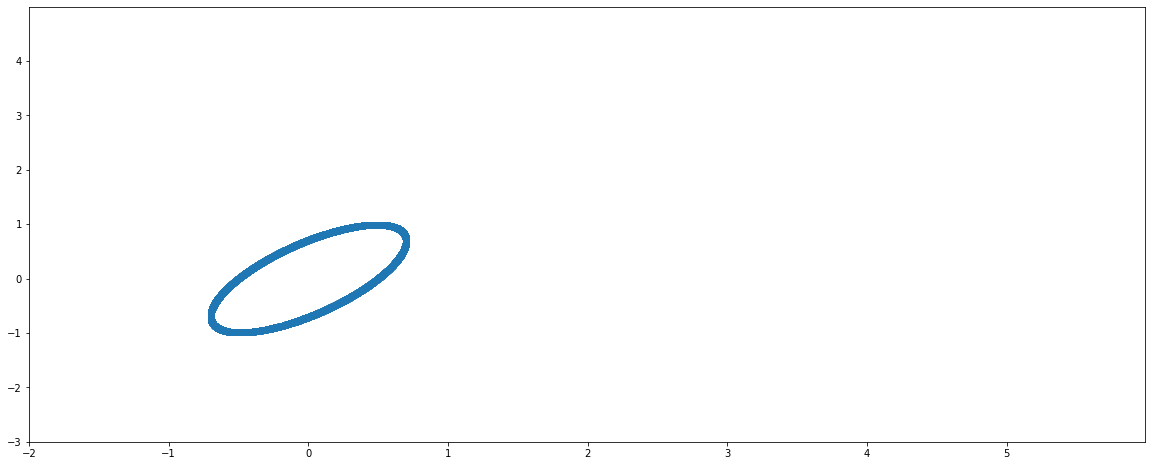

In [34]:
quick_MVN_scatter(samples1, target, levels=[z], alpha=0.2)

In [37]:
samples2 = zappa_persistent(x, ellipse, logf, logp_exp, n, sexp, tol, a_guess=1.0)

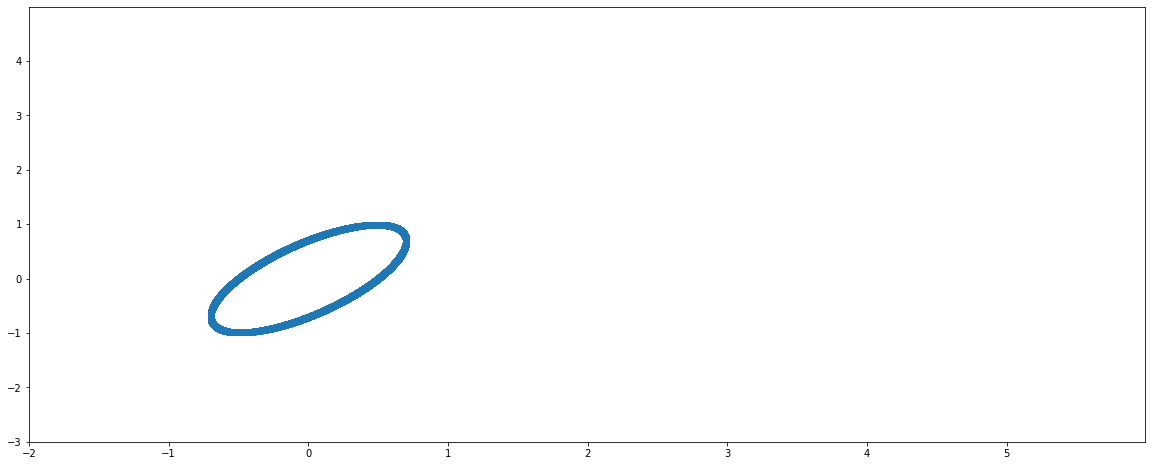

In [38]:
fig, ax = quick_MVN_scatter(samples2, target, levels=[z], alpha=0.2, return_axes=True)

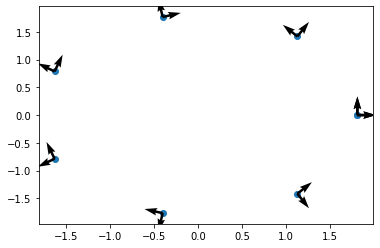

In [276]:
ellipse = RotatedEllipse(np.zeros(2), np.eye(2), z)
vals = np.linspace(0, 2*np.pi, 8)
points = ellipse.to_cartesian(vals[0])
for _ in range(1, len(vals)):
    points = np.vstack((points, ellipse.to_cartesian(vals[_])))
# Compute gradients
grads = []
tangs = []
for _ in range(len(vals)):
    Qx = ellipse.Q(points[_])
    grads.append(Qx)
    tangs.append(ellipse.tangent_basis(normalize(Qx)))
plt.scatter(*points.T)
plt.quiver(*points.T, *np.hstack(grads))
plt.quiver(*points.T, *np.hstack(tangs))

In [282]:
scipy.linalg.qr(ellipse.Q(points[1]))[0][:, 1:]

array([[-0.78183148],
       [ 0.6234898 ]])

In [329]:
np.sign(1 - 2)

-1

In [283]:
tangs[2]

array([[0.97492791],
       [0.22252093]])

In [286]:
tangs[1].T @  tangs[2]

array([[-0.6234898]])

In [291]:
    def angle_between(v1, v2):
        """"""
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [293]:
angle_between(tangs[1].flatten(), tangs[2].flatten())

2.2439947525641384

In [294]:
angle_between(tangs[1].flatten(), -tangs[2].flatten())

0.8975979010256548

In [299]:
points[:2]

array([[1.81473839, 0.        ],
       [1.13147088, 1.41881961]])

In [311]:
tangs[1].flatten()

array([-0.78183148,  0.6234898 ])

(-5, 5)

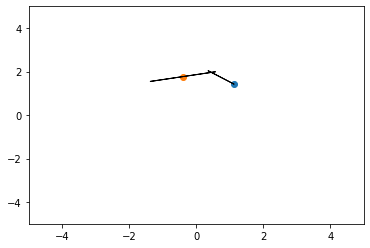

In [321]:
# 1
plt.scatter(*points[1])
t1 = tangs[1].flatten()
plt.arrow(x=points[1][0], y=points[1][1], dx=t1[0], dy=t1[1])
# 2
plt.scatter(*points[2])
t2 = tangs[2].flatten()
plt.arrow(x=points[2][0], y=points[2][1], dx=t2[0], dy=t2[1])
# -2
plt.arrow(x=points[2][0], y=points[2][1], dx=-t2[0], dy=-t2[1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [320]:
angle_between(t1, t2)

2.2439947525641384

In [322]:
angle_between(t1, -t2)

0.8975979010256548

In [273]:
np.hstack(tangs)

array([[-0.85170901,  0.75191139,  0.44702885, -0.12514033,  0.94201517,
         0.59693506,  0.24949613, -0.85170901],
       [ 0.52401503,  0.65926418,  0.89451954,  0.99213905,  0.3355703 ,
         0.80228956,  0.9683758 ,  0.52401503]])

In [269]:
grads

[array([[-0.95372048],
        [ 1.08774801]]), array([[-1.54787604],
        [ 0.77353843]]), array([[-0.97644937],
        [-0.12316136]]), array([[ 0.33026359],
        [-0.92711814]]), array([[ 1.38828133],
        [-1.03293605]]), array([[ 1.40089491],
        [-0.36093204]]), array([[0.35860605],
        [0.58286115]])]

Success:  True


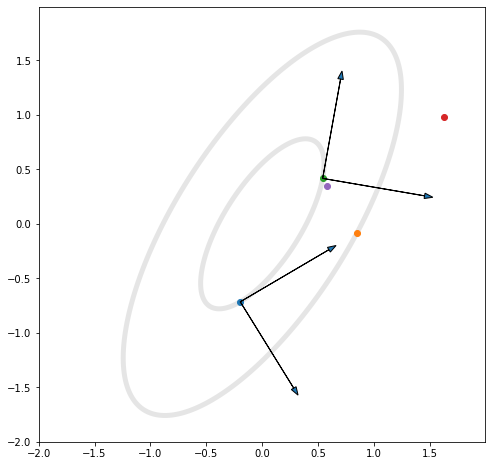

In [172]:
np.random.seed(5)

x = target.rvs()
z = target.pdf(x)

xlims=(-2, 2)
ylims=(-2, 2)
figsize=(8,8)
lw=5
alpha=0.2
colors='gray'
step=0.01

xxx, yyy = np.mgrid[xlims[0]:xlims[1]:step, ylims[0]:ylims[1]:step]
pos = np.dstack((xxx, yyy))
fig, ax = plt.subplots(figsize=figsize)


# compute gradient there
ellipse = RotatedEllipse(mu, Sigma, z)
Qx = ellipse.Q(x)
gx_basis = normalize(Qx)
tx_basis = ellipse.tangent_basis(Qx)
# sample
v_sample = s*np.random.randn(1)
v = tx_basis @ v_sample
a, flag = project(x, v, Qx, ellipse.q, tol, 1.0, 50)
y = x + v + a*Qx.flatten() 
Qy = ellipse.Q(y)
gy_basis = normalize(Qy)
ty_basis = ellipse.tangent_basis(Qy)
# Compute gradient at the point? Either with another manifold or with the gradient of the target?
#glp = -np.linalg.inv(Sigma) @ ((x + v) - mu)
vellipse = RotatedEllipse(mu, Sigma, target.pdf(x+v))
Qv = vellipse.Q((x+v))
gv_basis = normalize(Qv)
# Use the bouncing rule
vr = v - 2 * (v @ gv_basis.flatten()) * gv_basis.flatten()
# Use method by lelievre
proj = (x+v) - (np.outer(Qx, Qx) / (Qx.T @ Qx)) @ (x + v)
# Project the bounce

print("Success: ", flag)
levels = np.sort([z, target.pdf(x+v)])
ax.contour(xxx, yyy, target.pdf(pos), linewidths=lw, levels=levels, alpha=alpha, zorder=1, colors=colors) 
ax.scatter(*x)
ax.arrow(*x, *gx_basis.flatten(), length_includes_head=True, head_width=0.05)
ax.arrow(*x, *tx_basis.flatten(), length_includes_head=True, head_width=0.05)
ax.scatter(*(x+v))
ax.scatter(*y)
ax.arrow(*y, *gy_basis.flatten(), length_includes_head=True, head_width=0.05)
ax.arrow(*y, *ty_basis.flatten(), length_includes_head=True, head_width=0.05)
#ax.arrow(*(x+v), *gv_basis.flatten(), length_includes_head=True, head_width=0.05)
#ax.arrow(*(x+v), *vr,  length_includes_head=True, head_width=0.05)
ax.scatter(*(v+proj))
new = (x+v) - Qx.flatten() * (Qx.flatten() @ (x + v)) / (Qx.T @ Qx)
ax.scatter(*new.flatten())

In [168]:
v - Qx.flatten() * (Qx.flatten() @ (x + v)) / (Qx.T @ Qx)

array([[0.77695444, 1.06505323]])

In [113]:
v - 2 * (v @ gv_basis.flatten()) * gv_basis.flatten()

array([-0.08341596,  1.21251966])

In [132]:
(x + v) - (np.outer(Qx, Qx) / (Qx.T @ Qx)) @ (x + v)

array([0.57967847, 0.34963734])

In [148]:
np.outer(Qx.reshape(1, -1), Qx.reshape(1, -1))

array([[ 4.09077912, -6.78227504],
       [-6.78227504, 11.24461952]])

In [152]:
Qx.reshape(1, -1).T @ Qx.reshape(1, -1)

array([[ 4.09077912, -6.78227504],
       [-6.78227504, 11.24461952]])

In [108]:
np.sort([z, target.pdf(x+v)])

array([0.07274237, 0.13536131])